In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
genes = pd.read_csv("../../result/network_perturb_go/valid_genes", sep="\t")
id2genes = genes.set_index("ID")["genes"].to_dict()
genes2id = genes.set_index("genes")["ID"].to_dict()
genes = genes['genes'].values

In [3]:
meta = pd.read_csv("../../data/ENCODE_K562/metadata.tsv", sep="\t")
meta = meta[meta['Output type'] == "gene quantifications"]
meta = meta[meta['File assembly'] == "GRCh38"]
#meta.to_csv("../../data/ENCODE_K562/metadata_clean.tsv", sep="\t", index=False)

In [4]:
# with open("joblist", "w") as ff:
#     for fid in meta['File accession']:
#         ff.write("wget https://www.encodeproject.org/files/%s/@@download/%s.tsv\n" % (fid, fid))
# # downloaded files are moved to ../../data/ENCODE_K562/tsv/

In [5]:
result_df = pd.DataFrame([])
for eid in meta['File accession'].values:
    df = pd.read_csv("../../data/ENCODE_K562/tsv/%s.tsv" % eid, sep="\t")
    df = df[df['gene_id'].str.startswith("ENSG")]
    df = df.loc[:, ["gene_id", "TPM"]].copy()
    df.columns = ['gene_id', eid]
    if result_df.shape[0] == 0:
        result_df = df.copy()
    else:
        result_df = pd.merge(result_df, df, left_on='gene_id', right_on='gene_id')

In [6]:
data = sc.read_h5ad("../../data/perturb/K562_gwps_normalized_bulk_01.h5ad")
ensembl2name_dict = data.var["gene_name"].to_dict()

result_df['gene_id'] = result_df['gene_id'].str.split(".", expand=True)[0]
result_df['gene_id'] = result_df['gene_id'].map(ensembl2name_dict)
result_df = result_df[result_df['gene_id'].isin(genes)].copy()
result_df = result_df.set_index('gene_id')

In [7]:
exp_corr = result_df.T.corr()

In [8]:
corr = pd.DataFrame(exp_corr.values.reshape(-1))
corr[1] = list(exp_corr.index) * exp_corr.shape[0]
corr[2] = np.repeat(list(exp_corr.index), exp_corr.shape[0])

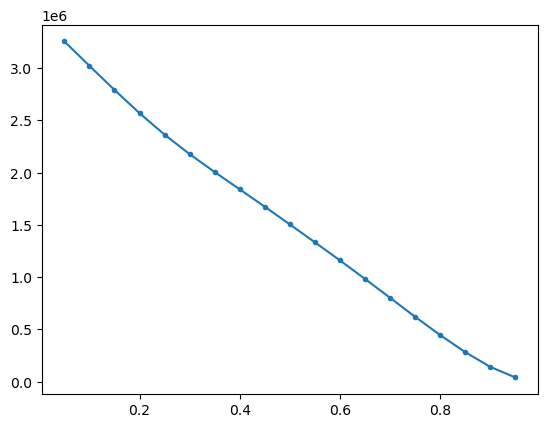

In [9]:
result = []
for ii in np.arange(0.05, 1, 0.05):
    sub_corr = corr.loc[corr[0].abs()>ii, [1, 2]] # threshold based on R2 of expression
    result.append(sub_corr.shape[0])
plt.plot(np.arange(0.05, 1, 0.05), result, ".-")

In [10]:
sub_corr = corr.loc[corr[0].abs()>0.75, [1, 2]] # threshold based on R2 of expression
sub_corr = sub_corr[sub_corr[1] != sub_corr[2]] # remove self loop

In [11]:
sub_corr[1] = sub_corr[1].map(genes2id)
sub_corr[2] = sub_corr[2].map(genes2id)

In [12]:
sub_corr.sort_values([1, 2]).to_csv("../../result/network_perturb_go/CoExpr_ENCODE_K562_0.75.tsv", sep="\t", header=False, index=False)